## Dicionário de dados

## Setup

### Importando bibliotecas

In [139]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark import SparkFiles
import pyspark.sql.functions as f
import plotly.express as px
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
import numpy as np
from scipy.spatial.distance import euclidean
import spotify_secret
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
import matplotlib.pyplot as plt
from skimage import io

SEED=1224

### Iniciando sessão Spark

In [2]:
sessao_spark = SparkSession.builder\
                           .appName("Recomendador de Músicas com Spark")\
                           .getOrCreate()
sessao_spark

your 131072x1 screen size is bogus. expect trouble
24/06/08 15:12:29 WARN Utils: Your hostname, DESKTOP-0IK5HAJ resolves to a loopback address: 127.0.1.1; using 172.24.179.174 instead (on interface eth0)
24/06/08 15:12:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 15:12:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Adicionando os arquivos no Spark

In [19]:
def add_and_get_file(url, arquivo):
    sessao_spark.sparkContext.addFile(url)
    return 'file://' + SparkFiles.get(arquivo)

path_dados_file = add_and_get_file('data/dados_musicas.csv','dados_musicas.csv')
path_dados_ano_file = add_and_get_file('data/dados_musicas_ano.csv','dados_musicas_ano.csv')
path_dados_generos_file = add_and_get_file('data/dados_musicas_genero.csv','dados_musicas_genero.csv')
# como foi inserido o proprio csv, eles possuem o mesmo nome, mas desta forma a url poderia apontar para um endereço em um repositório

24/06/08 15:27:11 WARN SparkContext: The path data/dados_musicas.csv has been added already. Overwriting of added paths is not supported in the current version.
24/06/08 15:27:11 WARN SparkContext: The path data/dados_musicas_ano.csv has been added already. Overwriting of added paths is not supported in the current version.
24/06/08 15:27:11 WARN SparkContext: The path data/dados_musicas_genero.csv has been added already. Overwriting of added paths is not supported in the current version.


## Análise dos dados

### Leitura dos dados

In [4]:
dados = sessao_spark.read.csv(path_dados_file, header=True, sep=';', inferSchema=True)

print(f'A base possui {dados.count()} linhas e {len(dados.columns)} colunas')
dados.limit(5).show()
dados.printSchema()

A base possui 20311 linhas e 19 colunas


+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+
|             0.285|2000|     0.00239|    Coldplay|       0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|         1.21E-4| 11|   0.234|             -7.227|   1|             Yellow|        84|     0.0281|173.372|   Coldpla

### Explorando os dados

In [5]:
dados.select([f.count(f.when(f.isnull(column), 1)).alias(column) for column in dados.columns]).show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|speechiness|tempo|artists_song|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|          0|    0|           0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+



In [6]:
sorted(dados.select('year').distinct().collect())

[Row(year=2000),
 Row(year=2001),
 Row(year=2002),
 Row(year=2003),
 Row(year=2004),
 Row(year=2005),
 Row(year=2006),
 Row(year=2007),
 Row(year=2008),
 Row(year=2009),
 Row(year=2010),
 Row(year=2011),
 Row(year=2012),
 Row(year=2013),
 Row(year=2014),
 Row(year=2015),
 Row(year=2016),
 Row(year=2017),
 Row(year=2018),
 Row(year=2019),
 Row(year=2020)]

In [7]:
dados_anos = sessao_spark.read.csv(path_dados_ano_file, header=True, sep=',', inferSchema=True)

print(f'A base possui {dados_anos.count()} linhas e {len(dados_anos.columns)} colunas')
dados_anos.limit(5).show()
dados_anos.printSchema()

A base possui 100 linhas e 14 colunas
+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|mode|year|      acousticness|      danceability|       duration_ms|             energy|   instrumentalness|          liveness|           loudness|        speechiness|             tempo|            valence|         popularity|key|
+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|   1|1921|0.8868960000000005|0.4185973333333336|260537.16666666663|0.23181513333333334|0.34487805886666656|           0.20571| -17.04866666666665|           0.073662|101.53149333333329|0.37932666666666665| 0.6533333333333333|  2|
|   1|1922|0.9385915492957748|0.482042

In [8]:
dados_anos = dados_anos.filter('year >= 2000')
print(f'A base possui {dados_anos.count()} linhas e {len(dados_anos.columns)} colunas')
dados_anos.limit(5).show()

A base possui 21 linhas e 14 colunas
+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+---+
|mode|year|       acousticness|      danceability|       duration_ms|            energy|   instrumentalness|           liveness|          loudness|        speechiness|             tempo|           valence|       popularity|key|
+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+---+
|   1|2000|0.28932270051635994| 0.590918047034764| 242724.6426380368|0.6254128323108387|0.10116776879345596| 0.1976860429447853|-8.247765848670758|0.08920541922290394| 118.9993231083843|0.5594754601226991| 46.6840490797546|  7|
|   1|2001| 0.2868424748428934|0.5833178553615969|2

In [15]:
columns_a = ['acousticness', 'danceability', 'duration_ms', 'energy',
             'instrumentalness', 'liveness', 'loudness','speechiness', 
             'tempo', 'valence', 'popularity']
fig = px.line(dados_anos.toPandas(), x='year', y=(columns_a), markers=True, title=f'Variação ao longo dos anos - selecione apenas um por vez para evitar distorção  (duplo clique)')
fig.show()

### Correlação

In [17]:
corr = px.imshow(dados_anos.drop('mode').toPandas().corr(), text_auto=True)
corr.show()

## Clusterização por gêneros

### StandardScaler

In [21]:
dados_generos = sessao_spark.read.csv(path_dados_generos_file, header=True, sep=',', inferSchema=True)

print(f'A base possui {dados_generos.count()} linhas e {len(dados_generos.columns)} colunas')
dados_generos.limit(5).show()
dados_generos.printSchema()

A base possui 2973 linhas e 14 colunas


+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+
|mode|              genres|      acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|        speechiness|             tempo|            valence|        popularity|key|
+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+
|   1|21st century clas...|0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|          0.60683367|             0.3616|-31.514333333333337|0.04056666666666667|           75.3365|0.10378333333333334| 27.83333333333333|  6|
|   

In [25]:
X = dados_generos.columns
X.remove('genres')
X

['mode',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

In [43]:
dados_generos_vector=VectorAssembler(inputCols=X,outputCol='features').transform(dados_generos).select(['genres','features'])
dados_generos_vector.limit(5).show()

+--------------------+--------------------+
|              genres|            features|
+--------------------+--------------------+
|21st century clas...|[1.0,0.9793333333...|
|               432hz|[1.0,0.49478,0.29...|
|               8-bit|[1.0,0.762,0.7120...|
|                  []|[1.0,0.6514170195...|
|          a cappella|[1.0,0.6765573049...|
+--------------------+--------------------+



In [44]:
scaler=StandardScaler(inputCol='features',outputCol='scaled_features')
scaler_model=scaler.fit(dados_generos_vector)
dados_generos_scaler=scaler_model.transform(dados_generos_vector)
dados_generos_scaler.limit(5).show()

+--------------------+--------------------+--------------------+
|              genres|            features|     scaled_features|
+--------------------+--------------------+--------------------+
|21st century clas...|[1.0,0.9793333333...|[2.68174831000279...|
|               432hz|[1.0,0.49478,0.29...|[2.68174831000279...|
|               8-bit|[1.0,0.762,0.7120...|[2.68174831000279...|
|                  []|[1.0,0.6514170195...|[2.68174831000279...|
|          a cappella|[1.0,0.6765573049...|[2.68174831000279...|
+--------------------+--------------------+--------------------+



### PCA

In [45]:
pca = PCA(k=2,inputCol='scaled_features',outputCol='pca_features')
model_pca = pca.fit(dados_generos_scaler)
dados_generos_pca = model_pca.transform(dados_generos_scaler)
dados_generos_pca.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|              genres|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+--------------------+
|21st century clas...|[1.0,0.9793333333...|[2.68174831000279...|[2.50709536688856...|
|               432hz|[1.0,0.49478,0.29...|[2.68174831000279...|[-0.5969679056633...|
|               8-bit|[1.0,0.762,0.7120...|[2.68174831000279...|[-4.1584602762235...|
|                  []|[1.0,0.6514170195...|[2.68174831000279...|[-2.3873448785122...|
|          a cappella|[1.0,0.6765573049...|[2.68174831000279...|[-2.6501218371679...|
+--------------------+--------------------+--------------------+--------------------+



### Pipeline

In [46]:
pca_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=X,outputCol='features'),
    StandardScaler(inputCol='features',outputCol='scaled_features'),
    PCA(k=2,inputCol='scaled_features',outputCol='pca_features')
])
pca_pipeline_model = pca_pipeline.fit(dados_generos)
pca_pipeline_pca = pca_pipeline_model.transform(dados_generos)
pca_pipeline_pca.limit(5).show()

+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|mode|              genres|      acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|        speechiness|             tempo|            valence|        popularity|key|            features|     scaled_features|        pca_features|
+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|   1|21st century clas...|0.9793333333333332|0.1628833333333333

### KMeans

In [47]:
kmeans=KMeans(featuresCol='pca_features',predictionCol='cluster_pca').setK(5).setSeed(SEED)
model_kmeans=kmeans.fit(dados_generos_pca)
predictions_kmeans=model_kmeans.transform(dados_generos_pca)
predictions_kmeans.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+-----------+
|              genres|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+--------------------+--------------------+--------------------+-----------+
|21st century clas...|[1.0,0.9793333333...|[2.68174831000279...|[2.50709536688856...|          2|
|               432hz|[1.0,0.49478,0.29...|[2.68174831000279...|[-0.5969679056633...|          2|
|               8-bit|[1.0,0.762,0.7120...|[2.68174831000279...|[-4.1584602762235...|          4|
|                  []|[1.0,0.6514170195...|[2.68174831000279...|[-2.3873448785122...|          0|
|          a cappella|[1.0,0.6765573049...|[2.68174831000279...|[-2.6501218371679...|          0|
+--------------------+--------------------+--------------------+--------------------+-----------+



### Plotando os Clusteres

In [50]:
pca_features_xy = predictions_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                                    .withColumn('y', vector_to_array('pca_features')[1])\
                                    .select(['cluster_pca','genres','x','y'])

pca_features_xy.limit(5).show()
fig = px.scatter(pca_features_xy.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x', 'y','genres'])
fig.show()

+-----------+--------------------+-------------------+-------------------+
|cluster_pca|              genres|                  x|                  y|
+-----------+--------------------+-------------------+-------------------+
|          2|21st century clas...|  2.507095366888567|0.43816913737697955|
|          2|               432hz|-0.5969679056633486|  4.981612052751347|
|          4|               8-bit| -4.158460276223561|-0.8366525081079937|
|          0|                  []| -2.387344878512217|-0.4877989015663406|
|          0|          a cappella|-2.6501218371679083|-0.5756819768820469|
+-----------+--------------------+-------------------+-------------------+



In [53]:
pca_pipeline_model.stages[2].explainedVariance

DenseVector([0.2975, 0.1212])

## Clusterização por músicas

In [56]:
columns_to_remove = ['artists','id','name','artists_song']
X = dados.columns
for col in columns_to_remove:
    X.remove(col)
X

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

In [64]:
dados_encoded_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados)

scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
model_scaler = scaler.fit(dados_encoded_vector)
dados_musicas_scaler = model_scaler.transform(dados_encoded_vector)

pca = PCA(k=len(X),inputCol='scaled_features',outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca = model_pca.transform(dados_musicas_scaler)

sum(model_pca.explainedVariance)*100

99.99999999999999

In [65]:
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(len(X))]
lista_valores

[0.21297354127107343,
 0.34597741622955064,
 0.43989805678254446,
 0.5267820578269102,
 0.6001038103117928,
 0.6665719513652388,
 0.7282174213581727,
 0.7845103843321022,
 0.8350002357002613,
 0.8812446547406768,
 0.9151737562703046,
 0.9435370133056037,
 0.9699018569070159,
 0.9900947792885578,
 0.9999999999999999]

In [66]:
pca = PCA(k=sum(np.array(lista_valores)<=0.7),inputCol='scaled_features',outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca_final = model_pca.transform(dados_musicas_scaler)
dados_musicas_pca_final.limit(5).show()
sum(model_pca.explainedVariance)*100

+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|            features|     scaled_features|        pca_features|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|             0.285|2000|     0.00239|    Coldplay| 

66.65719513652388

## Pipeline com KMeans

In [67]:
pca_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=X,outputCol='features'),
    StandardScaler(inputCol='features',outputCol='scaled_features'),
    PCA(k=6,inputCol='scaled_features',outputCol='pca_features')
])
pca_pipeline_model = pca_pipeline.fit(dados)
projection = pca_pipeline_model.transform(dados)
projection.limit(5).show()

+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|           valence|year|acousticness|     artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|               name|popularity|speechiness|  tempo|        artists_song|            features|     scaled_features|        pca_features|
+------------------+----+------------+------------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+--------------------+--------------------+--------------------+--------------------+
|             0.285|2000|     0.00239|    Coldplay| 

In [81]:
kmeans=KMeans(k=50,featuresCol='pca_features',predictionCol='cluster_pca',seed=SEED)
model_kmeans=kmeans.fit(projection)
prediction_kmeans=model_kmeans.transform(projection)

prediction_kmeans = prediction_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                                   .withColumn('y', vector_to_array('pca_features')[1])\
                                   .select(['cluster_pca','id','artists_song','pca_features','x','y'])

prediction_kmeans.limit(5).show()
fig = px.scatter(prediction_kmeans.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['artists_song'])
fig.show()

+-----------+--------------------+--------------------+--------------------+-------------------+-------------------+
|cluster_pca|                  id|        artists_song|        pca_features|                  x|                  y|
+-----------+--------------------+--------------------+--------------------+-------------------+-------------------+
|          8|3AJwUDP919kvQ9Qco...|   Coldplay - Yellow|[-34.710044647757...| -34.71004464775704|-165.36848784906184|
|          4|0I3q5fE6wg7LIfHGn...|OutKast - Ms. Jac...|[-36.498857627749...|-36.498857627749054|-167.85185045616558|
|         35|60a0Rd6pjrkxjPbaK...|Linkin Park - In ...|[-35.460300916940...|-35.460300916940554|-165.99633344577887|
|         16|6ZOBP3NvffbU4SZcr...|3 Doors Down - Kr...|[-35.563013255205...| -35.56301325520583|-165.59515096480607|
|         34|3yfqSUWxFvZELEM4P...|Eminem - The Real...|[-36.545569749075...| -36.54556974907567|-167.37512505802482|
+-----------+--------------------+--------------------+---------

## Distancia na música

In [82]:
nome_musica = 'Taylor Swift - Blank Space'

In [93]:
cluster = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
musicas_recomendadas = prediction_kmeans.filter(prediction_kmeans.cluster_pca == cluster)\
                                        .filter(prediction_kmeans.artists_song != nome_musica)\
                                        .select('artists_song','id','pca_features')
musicas_recomendadas.show()

+--------------------+--------------------+--------------------+
|        artists_song|                  id|        pca_features|
+--------------------+--------------------+--------------------+
|Usher - Yeah! (fe...|5rb9QrpfcKFHM1EUb...|[-36.050436933493...|
|Kelly Clarkson - ...|3xrn9i8zhNZsTtcoW...|[-35.191226411336...|
| Keyshia Cole - Love|0W4NhJhcqKCqEP2GI...|[-34.751332435196...|
|Mariah Carey - We...|3LmvfNUQtglbTryds...|[-35.144610288312...|
|Korn - Coming Undone|6p2liQLGoDaLXgND6...|[-35.272207170621...|
|Chris Brown - Yo ...|7DFnq8FYhHMCylykf...|[-35.112344117719...|
|  Aventura - Un Beso|1SaEt8dwTuLDzenUu...|[-34.134357732463...|
|Chris Brown - Say...|5F7IJrXD6Fa3EmqoY...|[-34.728839526520...|
|Red Hot Chili Pep...|10Nmj3JCNoMeBQ87u...|[-36.101793760083...|
|Craig Morgan - In...|0Ta3jOf8m9yCSWMVw...|[-35.227552248025...|
|Arctic Monkeys - ...|3geFzA6VBSNZUTmV3...|[-34.696049351615...|
|Arctic Monkeys - 505|58ge6dfP91o9oXMzq...|[-35.057671072817...|
|T-Pain - Buy U a ...|2aI

In [94]:
componentes_musica = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica)\
                                         .select('pca_features').collect()[0][0]
componentes_musica

DenseVector([-35.461, -166.9658, -12.7925, -137.9457, -13.1234, 4.1374])

In [99]:
def calcula_distancia(value):
    return euclidean(componentes_musica,value)

udf_calcula_distancia = f.udf(calcula_distancia,FloatType())

musicas_recomendadas = musicas_recomendadas.withColumn('dist',udf_calcula_distancia('pca_features'))

recomendacoes = sessao_spark.createDataFrame(musicas_recomendadas.sort('dist').take(10))
recomendacoes.show()

+--------------------+--------------------+--------------------+-------------------+
|        artists_song|                  id|        pca_features|               dist|
+--------------------+--------------------+--------------------+-------------------+
|Imagine Dragons -...|4uGY9CqDtGtaTTLg1...|[-35.357036076091...|0.37921473383903503|
|The All-American ...|6ihL9TjfRjadfEePz...|[-35.230574533645...| 0.6039153933525085|
|Darius Rucker - B...|36ISlLb12gKuCCVTY...|[-35.086961071907...| 0.6824935674667358|
|Old Dominion - Sn...|7I5fYc4qKJddht8Oz...|[-35.487363172957...| 0.7364036440849304|
|Dan + Shay - Noth...|4W38RXuQNuoTSwVsQ...|[-34.870758597317...| 0.7841535210609436|
|Twenty One Pilots...|7qxjGHW485TL8ciwk...|[-35.492243629066...| 0.8002141118049622|
|Jon Bellion - Mor...|2JXNOtb0ANe6MzgRY...|[-35.169883000344...| 0.8098159432411194|
|Kip Moore - More ...|73WWkaWkIRSP3MYGZ...|[-35.315882656922...| 0.8557121753692627|
|Calibre 50 - Corr...|0ehx1p1HMn7NMKisZ...|[-35.017275339788...| 

In [100]:
def recomendador(nome_musica):
    cluster = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
    
    musicas_recomendadas = prediction_kmeans.filter(prediction_kmeans.cluster_pca == cluster)\
                                            .filter(prediction_kmeans.artists_song != nome_musica)\
                                            .select('artists_song','id','pca_features')

    componentes_musica = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica)\
                                         .select('pca_features').collect()[0][0]

    udf_calcula_distancia = f.udf(calcula_distancia,FloatType())

    musicas_recomendadas = musicas_recomendadas.withColumn('dist',udf_calcula_distancia('pca_features'))

    recomendacoes = sessao_spark.createDataFrame(musicas_recomendadas.sort('dist').take(10))
    recomendacoes.select('artists_song').show()

In [103]:
nome_musica = 'Sum 41 - The Hell Song'
recomendador(nome_musica)

+-------------------------------------------------------------+
|artists_song                                                 |
+-------------------------------------------------------------+
|Kevin Gates - Don't Know What to Call It                     |
|Korn - Twisted Transistor                                    |
|Wisin & Yandel - Follow The Leader                           |
|Fall Out Boy - Save Rock And Roll                            |
|Melanie Martinez - Dollhouse                                 |
|Kanye West - Guilt Trip                                      |
|Yelawolf - Let's Roll                                        |
|Plies - Please Excuse My Hands (feat. Jamie Foxx & The-Dream)|
|Godsmack - When Legends Rise                                 |
|Hopsin - I Need Help                                         |
+-------------------------------------------------------------+



## API Spotify

In [132]:
OAuth = SpotifyOAuth(
    scope='user-library-read playlist-modify-private',
    redirect_uri='http://localhost/calback',
    client_id=spotify_secret.id,
    client_secret=spotify_secret.secret
)

client_credentials_manager = SpotifyClientCredentials(client_id=spotify_secret.id,client_secret=spotify_secret.secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [134]:
id = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('id').collect()[0][0]
sp.track(id)

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0qT79UgT5tY4yudH9VfsdT'},
    'href': 'https://api.spotify.com/v1/artists/0qT79UgT5tY4yudH9VfsdT',
    'id': '0qT79UgT5tY4yudH9VfsdT',
    'name': 'Sum 41',
    'type': 'artist',
    'uri': 'spotify:artist:0qT79UgT5tY4yudH9VfsdT'}],
  'available_markets': ['CR', 'MX', 'US'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/2kLmv0O8blKeM5HKxLtQrC'},
  'href': 'https://api.spotify.com/v1/albums/2kLmv0O8blKeM5HKxLtQrC',
  'id': '2kLmv0O8blKeM5HKxLtQrC',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab67616d0000b2735f897ffe64efe64404d7a8a6',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/ab67616d00001e025f897ffe64efe64404d7a8a6',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/ab67616d000048515f897ffe64efe64404d7a8a6',
    'width': 64}],
  'name': 'Does This Look Infected?',
  'release_date': '200

In [135]:
def recomendador(nome_musica):

    # seleciona as músicas recomendadas
    cluster = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
    
    musicas_recomendadas = prediction_kmeans.filter(prediction_kmeans.cluster_pca == cluster)\
                                            .filter(prediction_kmeans.artists_song != nome_musica)\
                                            .select('artists_song','id','pca_features')

    componentes_musica = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica)\
                                         .select('pca_features').collect()[0][0]

    udf_calcula_distancia = f.udf(calcula_distancia,FloatType())

    musicas_recomendadas = musicas_recomendadas.withColumn('dist',udf_calcula_distancia('pca_features'))

    recomendacoes = sessao_spark.createDataFrame(musicas_recomendadas.sort('dist').take(10))
    recomendacoes.select('artists_song').show(truncate=False)

    # Extrai informações da API
    playlist_id = recomendacoes.select('id').collect()[0]
    playlist_track = []

    for id in playlist_id:
        playlist_track.append(sp.track(id))

    return playlist_track

In [136]:
nome_musica = 'Sum 41 - The Hell Song'
recomendador(nome_musica)

+-------------------------------------------------------------+
|artists_song                                                 |
+-------------------------------------------------------------+
|Kevin Gates - Don't Know What to Call It                     |
|Korn - Twisted Transistor                                    |
|Wisin & Yandel - Follow The Leader                           |
|Fall Out Boy - Save Rock And Roll                            |
|Melanie Martinez - Dollhouse                                 |
|Kanye West - Guilt Trip                                      |
|Yelawolf - Let's Roll                                        |
|Plies - Please Excuse My Hands (feat. Jamie Foxx & The-Dream)|
|Godsmack - When Legends Rise                                 |
|Hopsin - I Need Help                                         |
+-------------------------------------------------------------+



[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1gPhS1zisyXr5dHTYZyiMe'},
     'href': 'https://api.spotify.com/v1/artists/1gPhS1zisyXr5dHTYZyiMe',
     'id': '1gPhS1zisyXr5dHTYZyiMe',
     'name': 'Kevin Gates',
     'type': 'artist',
     'uri': 'spotify:artist:1gPhS1zisyXr5dHTYZyiMe'}],
   'available_markets': ['AR',
    'AU',
    'AT',
    'BE',
    'BO',
    'BR',
    'BG',
    'CA',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DK',
    'DO',
    'DE',
    'EC',
    'EE',
    'SV',
    'FI',
    'FR',
    'GR',
    'GT',
    'HN',
    'HK',
    'HU',
    'IS',
    'IE',
    'IT',
    'LV',
    'LT',
    'LU',
    'MY',
    'MT',
    'MX',
    'NL',
    'NZ',
    'NI',
    'NO',
    'PA',
    'PY',
    'PE',
    'PH',
    'PL',
    'PT',
    'SG',
    'SK',
    'ES',
    'SE',
    'CH',
    'TW',
    'TR',
    'UY',
    'US',
    'GB',
    'AD',
    'LI',
    'MC',
    'ID',
    'JP',
    'TH',
    'VN',
   

## Imagem do album

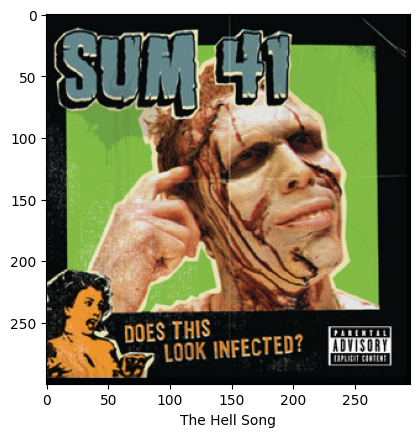

In [142]:
nome_musica = 'Sum 41 - The Hell Song'

id = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('id').collect()[0][0]

track = sp.track(id)

url = track['album']['images'][1]['url']
name = track['name']

image = io.imread(url)
plt.imshow(image)
plt.xlabel(name, fontsize=10)
plt.show()

In [153]:
def recomendador(nome_musica):

    # seleciona as músicas recomendadas
    cluster = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
    
    musicas_recomendadas = prediction_kmeans.filter(prediction_kmeans.cluster_pca == cluster)\
                                            .filter(prediction_kmeans.artists_song != nome_musica)\
                                            .select('artists_song','id','pca_features')

    componentes_musica = prediction_kmeans.filter(prediction_kmeans.artists_song == nome_musica)\
                                         .select('pca_features').collect()[0][0]

    udf_calcula_distancia = f.udf(calcula_distancia,FloatType())

    musicas_recomendadas = musicas_recomendadas.withColumn('dist',udf_calcula_distancia('pca_features'))

    recomendacoes = sessao_spark.createDataFrame(musicas_recomendadas.sort('dist').take(10))

    # Extrai informações da API
    playlist_id = recomendacoes.select('id').collect()
    name = []
    url = []
    for i in playlist_id:
        track = sp.track(i[0])
        url.append(track['album']['images'][1]['url'])
        name.append(track['name'])

    plt.figure(figsize=(15,10))
    columns=5
    for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns+1, columns, i+1)
        image=io.imread(u)
        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
        plt.xticks(color='w',fontsize=0.1)
        plt.yticks(color='w',fontsize=0.1)
        plt.xlabel(name[i],fontsize=10)
        plt.tight_layout(h_pad=0.7,w_pad=0)
        plt.subplots_adjust(wspace=None,hspace=None)
        plt.grid(visible=None)

    plt.show()

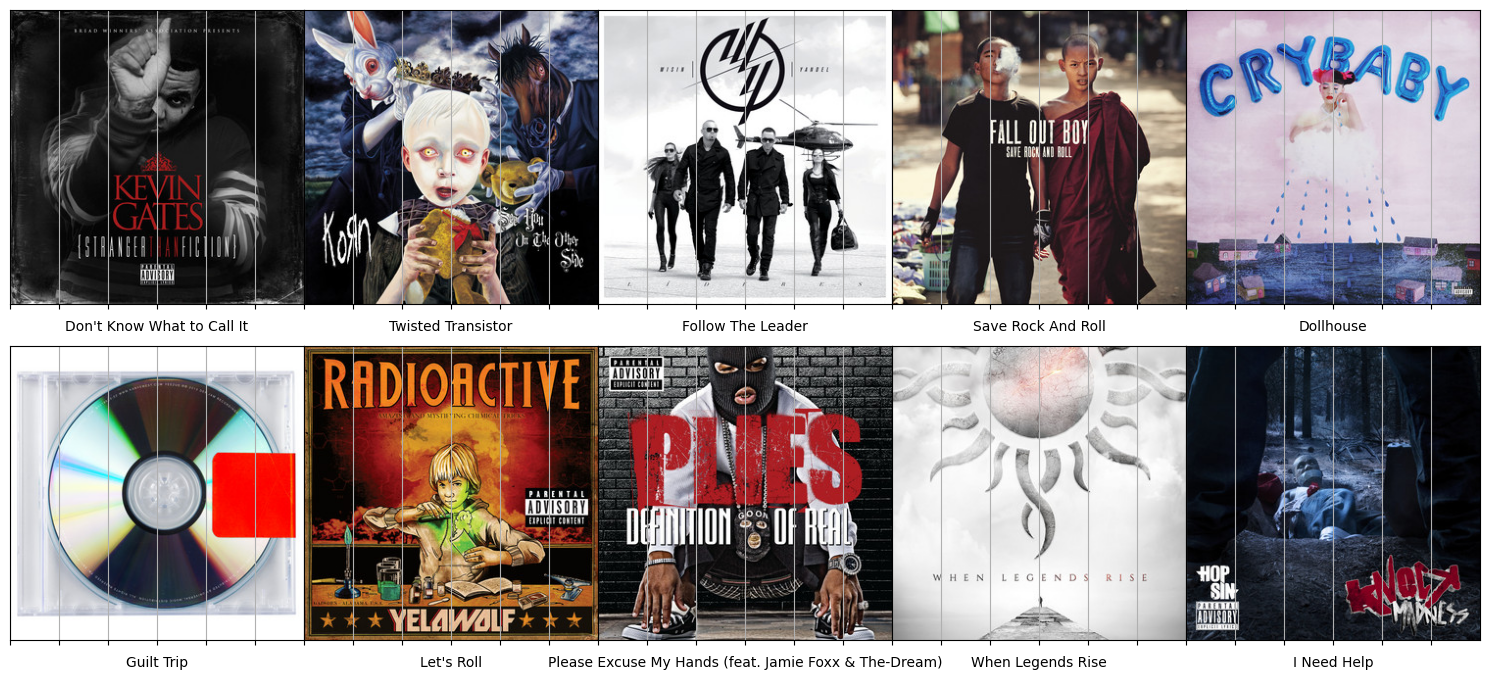

In [154]:
nome_musica = 'Sum 41 - The Hell Song'
recomendador(nome_musica)